In [ ]:
pip install librosa

In [18]:
import os
import urllib.request

# URL to download the script from
branch = 'main'  # or whichever branch you want to use
url = f'https://raw.githubusercontent.com/NVIDIA/NeMo/{branch}/scripts/dataset_processing/process_speech_commands_data.py'
file_path = 'process_speech_commands_data.py'

# Check if the file already exists
if not os.path.exists(file_path):
    print(f"{file_path} not found. Downloading from {url}...")
    
    # Use urllib to download the file
    urllib.request.urlretrieve(url, file_path)
    
    print(f"{file_path} downloaded successfully!")
else:
    print(f"{file_path} already exists.")

process_speech_commands_data.py already exists.


In [20]:
import numpy as np
import librosa
import scipy.signal as signal
import os


python process_speech_commands_data.py --data_root C:\Users\naikg\keyword-spotting\data --data_version 2 --class_split  all --num_processes 4 --rebalance --log

In [21]:
# Read file paths and labels from the text file
def read_file_paths_and_labels(file_list_path):
    file_paths = []
    labels = []
    with open(file_list_path, 'r') as file:
        for line in file:
            
            
            line = line.strip() 
            # Remove any leading/trailing whitespace
            if line:
                label, filename = line.split('/', 1)
                
                full_path = os.path.join("C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2", line)
                
                file_paths.append(full_path)
                labels.append(label)
    return file_paths, labels

# Example file list path
file_list_path = 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\testing_list.txt'
file_paths, labels = read_file_paths_and_labels(file_list_path)

# Load and process all audio files
audio_data = {}

In [22]:
file_paths

['C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/bb05582b_nohash_3.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/97f4c236_nohash_2.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/f2e59fea_nohash_3.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/fdb5155e_nohash_2.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/dc75148d_nohash_0.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/3f170018_nohash_0.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/18f8afd5_nohash_3.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/e1469561_nohash_1.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recognition_v2\\right/5c8af87a_nohash_0.wav',
 'C:\\Users\\naikg\\keyword-spotting\\data\\google_speech_recogn

In [23]:
import numpy as np
import librosa
import os


def load_audio(file_path, sr=16000):
    # Load the audio file with librosa
    audio, sample_rate = librosa.load(file_path, sr=sr)
    return audio, sample_rate

def load_all_audios_from_directory(directory, sr=16000):
    audio_data = {}

In [24]:


def normalize_audio(audio):
    return librosa.util.normalize(audio)

def normalize_all_audios(audio_data):
    normalized_audio_data = {}
    
    for file_name, (audio, sample_rate) in audio_data.items():
        normalized_audio = normalize_audio(audio)
        normalized_audio_data[file_name] = (normalized_audio, sample_rate)
    
    return normalized_audio_data



# Now 'normalized_audio_files' contains a dictionary with file names as keys and (normalized_audio, sample_rate) as values


In [25]:
def extract_mel_spectrogram(audio, sr, n_mels=40, hop_length=512, n_fft=2048):
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, hop_length=hop_length, n_fft=n_fft)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to log scale (dB)
    return mel_spec_db

def extract_mel_spectrograms(audio_data, n_mels=40, hop_length=512, n_fft=2048):
    mel_spectrograms = {}
    
    for file_name, (audio, sr) in audio_data.items():
        mel_spec = extract_mel_spectrogram(audio, sr, n_mels, hop_length, n_fft)
        mel_spectrograms[file_name] = mel_spec
    
    return mel_spectrograms

In [26]:
def extract_mfcc(audio, sr, n_mfcc=13, hop_length=512, n_fft=2048):
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=hop_length, n_fft=n_fft)
    return mfcc

def extract_mfcc_features(audio_data, **kwargs):
    features = {}
    
    for file_name, (audio, sr) in audio_data.items():
        feature = extract_mfcc(audio, sr, **kwargs)
        features[file_name] = feature
    
    return features

In [27]:
import numpy as np


def pad_or_trim_audio(audio, max_length, sr):
    """
    Pads or trims the audio to ensure it has a fixed length.

    Args:
        audio (numpy array): The audio data.
        max_length (float): Desired length of the audio in seconds.
        sr (int): Sample rate of the audio.

    Returns:
        numpy array: Audio data padded or trimmed to the desired length.
    """
    # Calculate the target length in samples
    target_length = int(max_length * sr)

    # Trim if longer than target length
    if len(audio) > target_length:
        return audio[:target_length]
    # Pad with zeros if shorter than target length
    else:
        return np.pad(audio, (0, target_length - len(audio)))


def pad_or_trim_audios(normalized_audio_files):
    audio_fixed_length = {}
    
    for file_name, (audio, sample_rate) in normalized_audio_files.items():
        audio_length =pad_or_trim_audio(audio, max_length=1.0, sr=sample_rate)
        audio_fixed_length[file_name] =audio_length
    
    return audio_fixed_length


In [10]:
import numpy as np
import scipy.signal as signal  # For Wiener filtering

# Wiener filtering for noise reduction
def reduce_noise_wiener(audio):
    """
    Reduces noise from the audio using Wiener filtering.
    
    Args:
        audio (numpy array): The input audio data.
    
    Returns:
        numpy array: The audio with noise reduced using Wiener filtering.
    """
    # Apply Wiener filter to reduce noise
    reduced_noise_audio = signal.wiener(audio)
    return reduced_noise_audio

In [11]:
features_list = []
labels_list = []
for file_path in file_paths:
    print(file_path)
    audio, sr = load_audio(file_path)
    normalized_audio = normalize_audio(audio)
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
    mel_spectrogram_features = extract_mel_spectrogram(normalized_audio,sr)
    mfcc_features =extract_mfcc(normalized_audio,sr, n_mfcc=13, hop_length=512, n_fft=2048)
    features_list.append(mfcc_features)
    labels_list.append(labels[file_paths.index(file_path)])



C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/4620dc14_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/83957201_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8494fba8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b7e9f841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b83c1acf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c518d1b1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d103dd6e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a1533da4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/283d7a53_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/af130f12_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/964c7c9e_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/aef8dcf5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e9901cf0_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44715c1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44715c1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/c9e251d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\googl

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5170b77f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/3b4f8f24_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spottin

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/1acc97de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/0cb74144_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5b1db3ee_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/84d1e469_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/adebe223_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/2d82a556_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/587f3271_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d2dd5785_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/7dc95912_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/37dca74f_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/dc75148d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/62ff07ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/44715c1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/26b28ea7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/44715c1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3659fc1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/4f8ef132_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8494fba8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b7e9f841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0bac8a71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/553f1a79_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a80f9f53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/18f8afd5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bb05582b_nohash_4.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a9f54d8d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0ea0e2f4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/7192fddc_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fe1916ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/798f702a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/370844f7_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fb7eb481_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0c40e715_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/6205088b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f292725f_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/f428ca69_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/553f1a79_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5ff3f9a1_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/553f1a79_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9e2ce5e3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/c9b5ff26_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/8ea6dec6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/af8b2f2c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/370844f7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/412c675c_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/28497c5b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/881583a6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/28497c5b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/18f8afd5_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_11.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/67961766_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/837a0f64_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3d86b69a_nohash_3.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/863880b7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5744b6a7_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/83957201_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/0cb74144_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8a325749_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b83c1acf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/94de6a6a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/82b99576_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bfd26d6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e0c782d5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/63f7a489_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d0faf7e4_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/20d3f11f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d103dd6e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/90b94017_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/87070229_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/6e916de8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a591c2ea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d7467392_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/47d01978_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2005ca25_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2fa39636_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/b83c1acf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/1f3bece8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/82b99576_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/82b99576_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2005ca25_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2fa39636_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/47d01978_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/bfd26d6b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/27e6f0f0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d962e5ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d962e5ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/893705bb_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/bfd26d6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/b7e9f841_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d103dd6e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5f814c23_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3b4f8f24_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/91b03183_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5e3dde6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6205088b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c7124b73_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9d4bab4f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/67961766_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fce96bac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/837a0f64_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a9f54d8d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/bb31b82b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9a7c1f83_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4f8ef132_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_16.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5c8af87a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/aef8dcf5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sto

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/43fc47a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/37fc5d97_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a1533da4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fa446c16_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fa446c16_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0fa1e7a9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b83c1acf_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a7c1f83_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f297e878_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f428ca69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe52b97_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3efef882_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a80f9f53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/18f8afd5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9dc1889e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3b4f8f24_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/863880b7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/587f3271_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fe1916ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/798f702a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/0c40e715_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5ff3f9a1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3efef882_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4a0e2c16_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/ffb86d3c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/7dc95912_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/ca48dc76_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/798f702a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aa80f517_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/adebe223_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c518d1b1_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/27c30960_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c841771_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4fd1443e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/42beb5eb_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0487ba9b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/50033893_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5e3dde6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/db24628d_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fb7eb481_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/1b4c9b89_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/6021f08b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/dfdabe19_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/94de6a6a_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9b3ea809_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f9643d42_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b97c9f77_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cc592808_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5c8af87a_

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/0b57a6ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/6b889021_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/bed06fac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/2c6d3924_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/44715c1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/85d2ac4b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/b7e9f841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/f292725f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e71b4ce6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/18f8afd5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f2e59fea_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f653d27_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a9f54d8d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/3b4f8f24_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/db24628d_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca48dc76_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1acc97de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e5e54cee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f3bece8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b83c1acf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2005ca25_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f264e0df_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9b3ea809_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/62ff07ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/97f4c236_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/563aa4e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e9901cf0_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4290ca61_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4c841771_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b2e2773a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bed06fac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b49caed3_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/94de6a6a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/caedb73a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5828dfa2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f5496439_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/94de6a6a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bfd26d6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e0c782d5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f264e0df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/63f7a489_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c518d1b1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/fdb5155e_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/893705bb_nohash_12.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37fc5d97_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c841771_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ef2a3cfb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/210f3aa9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0d53e045_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cfde27ba_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8ea6dec6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/653a48f5_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c7c95de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d0faf7e4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bfd26d6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2005ca25_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2fa39636_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/2d82a556_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/80c45ed6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/67961766_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/840c366d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9d4bab4f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/24ad3ebe_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fce96bac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/840c366d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/893705bb_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a9f54d8d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/0ea0e2f4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d9e9f554_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b11a05d2_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fa446c16_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/db24628d_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a2473d62_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/af7a8296_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c0e0f834_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/1f653d27_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/40c4e774_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/2796ac50_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/8a325749_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/8a325749_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/aa233654_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0c540988_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/f5496439_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4c7c95de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/fdb5155e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/84d1e469_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e1469561_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/27c30960_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0f250098_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c841771_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b49caed3_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/26b28ea7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/26b28ea7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0c540988_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1b4c9b89_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/18f8afd

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fce96bac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e41a903b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bed06fac_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ffa76c4a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/7dc95912_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/1b4c9b89_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f264e0df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b83c1acf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b83c1acf_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5ff3f9a1_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/105a0eea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d103dd6e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5f814c23_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/7e1054e7_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/370844f7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fb7eb481_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cd85758f_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d0faf7e4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bfd26d6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/47d01978_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b83c1acf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1f3bece8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/82b99576_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e5e54cee_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bb05582b_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/a8e25ebb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c6167ca_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c841771_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/37fc5d97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c6167ca_nohash_4.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d9e9f554_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5e3dde6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/fb7eb481_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/6f2f57c1_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bfd26d6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/6021f08b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b83c1acf_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b83c1acf_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/6021f08b_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/a60a09cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f428ca69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9b5f

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964c7c9e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a80f9f53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f2e59fea_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4a0e2c16_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bb05582b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/105a0eea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8625475c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b11a05d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5744b6a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964e8cfd_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7add4c5f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7dc95912_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/fb7eb481_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f297e878_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c7c95de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/e0c782d5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/68dd409e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/62ff07ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/97f4c236_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/563aa4e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/84d1e469_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e1469561_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4fd1443e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4845bb10_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4c6167ca_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d962e5ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d962e5ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f6af2457_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/8ec6dab6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4c6167ca_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/653a48f5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/653a48f5_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d5b963aa_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a4383927_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f9643d42_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9d171fee_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0c40e715_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5c8af87a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d5ca80c6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/faf2576f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7dc95912_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4c7c95de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

In [28]:
features_list = []
labels_list = []

for file_path, label in zip(file_paths, labels):
    print(file_path)
    
    # Load the audio file
    audio, sr = load_audio(file_path)
    
    # Reduce noise using Wiener filtering
    denoised_audio = reduce_noise_wiener(audio)
    
    # Normalize the audio
    normalized_audio = normalize_audio(denoised_audio)
    
    # Pad or trim the audio to a fixed length of 1.0 second
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
    
    # Extract mel spectrogram features
    mel_spectrogram_features = extract_mel_spectrogram(padded_audio, sr)
    
    # Extract MFCC features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)
    
    # Append the MFCC features (or combine both features)
    features_list.append(mfcc_features)  # Optionally: np.concatenate([mfcc_features, mel_spectrogram_features])
    
    # Append the corresponding label
    labels_list.append(label)

# Now, features_list contains Wiener-filtered MFCC features and labels_list contains labels for each audio file

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/6b889021_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/4620dc14_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/83957201_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b7e9f841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b83c1acf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/94de6a6a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bfd26d6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c518d1b1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d103dd6e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/91b03183_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d0faf7e4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/af130f12_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/964c7c9e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/3efef882_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/5ff3f9a1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/840c366d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e41a903b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/fe1916ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/bb31b82b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/4620dc14_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/83957201_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e9901cf0_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/84d1e469_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8c7f81df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/f0ae7203_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8625475c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/daf230ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/412c675c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/422d3197_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/653a48f5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/aa80f517_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spottin

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/fb7eb481_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spottin

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bfd26d6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5b1db3ee_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/67961766_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c0e0f834_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/553f1a79_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/7dc95912_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c781f251_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5828dfa2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/dfdabe19_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5828dfa2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c22d3f18_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/964c7c9e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3efef882_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/840c366d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3efef882_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/1f653d27_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/cfde27ba_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/bb31b82b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/28497c5b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5c8af87a_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/837a0f64_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/553f1a79_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5c8af87a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/893705bb_nohash_10.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d5ca80c6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cfbedff9_nohash_0.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/26b28ea7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8db999cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5e3dde6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/db24628d_nohash_4.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b737ee80_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8056e897_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9d171fee_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/8769c34c_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a7216980_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b7e9f841_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bfd26d6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e0c782d5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ea356919_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f264e0df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/63f7a489_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d5b963aa_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/43fc47a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/ef2a3cfb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/210f3aa9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/caf9fceb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/283d7a53_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/283d7a53_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/caedb73a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/b737ee80_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/7bae88ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/3df9a3d4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/b737ee80_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/dfdabe19_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/0fa1e7a9_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e1469561_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8c7f81df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d91a159e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3d86b69a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/881583a6_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d962e5ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1093c8e7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8ec6dab6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1fe4c891_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1cb788bc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/03401e93_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af8b2f2c_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f9643d42_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/881583a6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8c7f81df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/44260689_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/af405b69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c518d1b1_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/422d3197_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/af8b2f2c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/b49caed3_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/f292725f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c9e251d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recog

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/3659fc1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/db24628d_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/fb7eb481_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5c8af87a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6f2f57c1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4620dc14_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8c7f81df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5c8af87a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f428ca69_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1fe4c891_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1cb788bc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/03401e93_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/412c675c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca48dc76_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b83c1acf_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/6021f08b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cc592808_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a60a09cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/68dd409e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/bb05582b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9dc1889e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffb86d3c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffb86d3c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_11.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sto

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fa446c16_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fe1916ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f297e878_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0c40e715_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/97f4c236_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/563aa4e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e9901cf0_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/dc75148d_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe52b97_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c6167ca_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ef2a3cfb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/43fc47a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4845bb10_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3659fc1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5e3dde6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5170b77f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fb7eb481_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/7bae88ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3df9a3d4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b737ee80_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f292725f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af130f12_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/e9901cf0_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/24ad3ebe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_rec

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/283d7a53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a1533da4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/0d53e045_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/a591c2ea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/135c6841_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/aa233654_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/6021f08b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/f297e878_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/47d01978_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/2fa39636_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/adebe223_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/af405b69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c518d1b1_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/210f3aa9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d103dd6e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5f814c23_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/87070229_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d1a4fb3f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/daf230ac_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/81dc4a94_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8494fba8_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d0faf7e4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a2473d62_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bfd26d6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/47d01978_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/2005ca25_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/28497c5b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/881583a6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8c7f81df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/7dc95912_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/bb31b82b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/ca48dc76_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c7124b73_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d1bf406b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/44260689_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/84d1e469_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/553f1a79_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5c8af87a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1f653d27_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/7dc95912_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0c40e715_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5c8af87a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5b1db3ee_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/adebe223_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a356ab9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/6e916de8_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a1533da4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/964e8cfd_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/412c675c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/dfdabe19_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/caedb73a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b737ee80_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/dcb57584_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f9643d42_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a7c1f83_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/68dd409e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/dc75148d_nohash

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/840c366d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e71b4ce6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/893705bb_nohash_13.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d103dd6e_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/964e8cfd_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a6f2fd71_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e5e54cee_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e5e54cee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b83c1acf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2fa39636_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ea356919_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0cb74144_nohash_3.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/f2e59fea_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/e49428d9_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/e49428d9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/63f7a489_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/bfd26d6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/dfdabe19_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/d5b963aa_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/a80f9f53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/67961766_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/c0e0f834_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/7add4c5f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/d1a4fb3f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/af130f12_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bb05582b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/893705bb_nohash_10.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d5ca80c6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/2796ac50_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b2e2773a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d962e5ac_

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7192fddc_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/6f2f57c1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/6b889021_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bb31b82b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1b4c9b89_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d5b963aa_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0f250098_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/43fc47a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0f250098_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/43fc47a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/210f3aa9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4c7c95de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/7bae88ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/3df9a3d4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/b737ee80_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/2aa787cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0fa1e7a9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e1469561_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5c8af87a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/6f689791_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/881583a6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0f250098_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c841771_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/ef2a3cfb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4fd1443e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/42beb5eb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/26b28ea7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/2c6d3924_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3659fc1c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5e3dde6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/fb7eb481_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1b4c9b89_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9a7c1f83_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/ad6a46f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/63f7a489_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/7257420c

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9e2ce5e3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fce96bac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e41a903b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9a69672b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/964e8cfd_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ffa76c4a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/7dc95912_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c22d3f18_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cc592808_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9a7c1f83_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/f264e0df_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c9b5ff26_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5f814c23_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/105a0eea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d103dd6e_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d1a4fb3f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5e3dde6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/370844f7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5170b77f_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6205088b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5b963aa_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_14.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9d4bab4f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_0.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_10.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c841771_nohash_1.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b11a05d2_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b49caed3_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/3b4f8f24_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/caedb73a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/94de6a6a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/a4383927_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f5496439_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c22d3f18_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8769c34c_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/a7216980_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b83c1acf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bfd26d6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e0c782d5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f9643d42_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4a0e2c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/2d82a556_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964c7c9e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/105a0eea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/20d3f11f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5f814c23_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/caf9fceb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7e1054e7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/87070229_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/3b4f8f24_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/91b03183_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bfd26d6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/dfdabe19_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/2aa787cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/dfdabe19_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9b3ea809_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f9643d42_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b97c9f77_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4f8ef132_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/95ba4996_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a7c1f83_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/84d1e469_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9d4bab4f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/837a0f64_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d056d4d8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/67961766_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c0e0f834_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fce96bac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/80c45ed6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/692a88e6_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/44715c1c_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0cb74144_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/caedb73a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/8a325749_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/94de6a6a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/caedb73a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a4383927_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4620dc14_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9a7c1f83_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/81dc4a94_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/63f7a489_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af130f12_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/20d3f11f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c7dc7278_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/48a8a69d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5f814c23_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7e1054e7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/87070229_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/6e916de8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/85834399_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7dc95912_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/cfde27ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/964e8cfd_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7add4c5f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

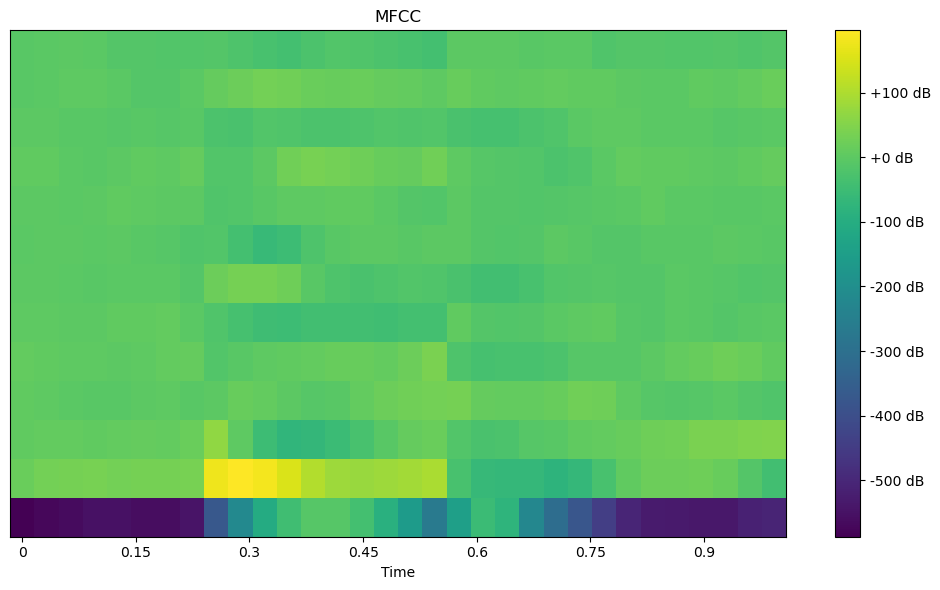

In [12]:
import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc(mfcc, sr):
    """
    Plots the MFCCs as a heatmap.

    Args:
        mfcc (numpy array): The MFCC features.
        sr (int): The sample rate of the audio.
    """
    plt.figure(figsize=(10, 6))
    # Display MFCC as a heatmap
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example usage after extracting MFCC features
file_path = file_paths[0]  # Plot MFCC for the first file in file_paths as an example
audio, sr = load_audio(file_path)
normalized_audio = normalize_audio(audio)
padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)

# Plot the MFCC features
plot_mfcc(mfcc_features, sr)

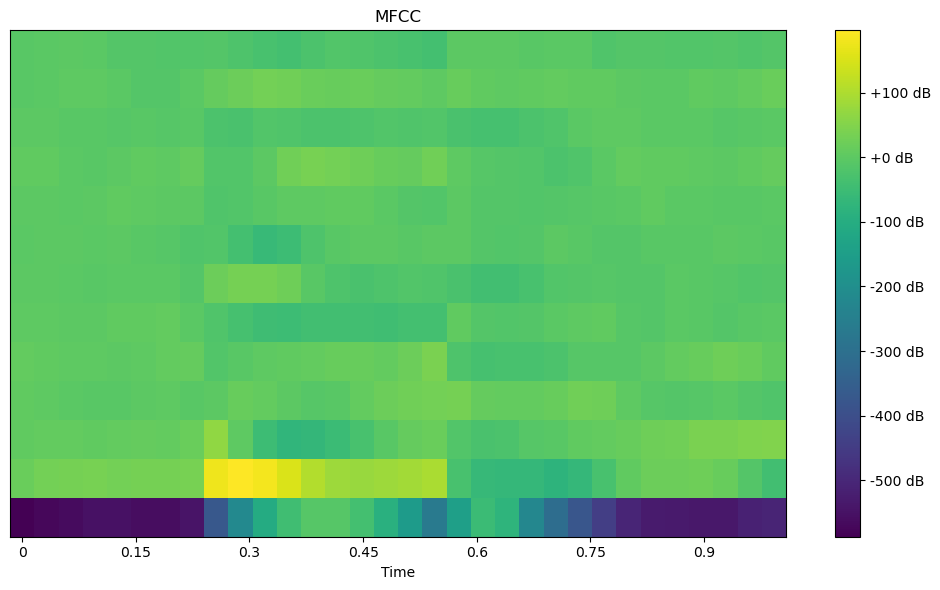

In [14]:
import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc(mfcc, sr):
    """
    Plots the MFCCs as a heatmap.

    Args:
        mfcc (numpy array): The MFCC features.
        sr (int): The sample rate of the audio.
    """
    plt.figure(figsize=(10, 6))
    # Display MFCC as a heatmap
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example usage after extracting MFCC features
file_path = file_paths[0]  # Plot MFCC for the first file in file_paths as an example
audio, sr = load_audio(file_path)
normalized_audio = normalize_audio(audio)
padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)

# Plot the MFCC features
plot_mfcc(mfcc_features, sr)

In [15]:
import numpy as np
import librosa

def spectral_subtraction(audio, sr, noise_estimation_duration=1.0):
    """
    Apply spectral subtraction for noise reduction.

    Args:
        audio (numpy array): The input audio signal.
        sr (int): Sample rate of the audio.
        noise_estimation_duration (float): Duration to estimate noise in seconds.

    Returns:
        numpy array: The noise-reduced audio signal.
    """
    # Estimate noise from the initial portion of the audio
    noise_estimation_samples = int(noise_estimation_duration * sr)
    noise_estimate = np.mean(np.abs(audio[:noise_estimation_samples]))  # Simple estimate

    # Perform FFT
    fft_audio = np.fft.fft(audio)
    magnitude = np.abs(fft_audio)
    phase = np.angle(fft_audio)

    # Subtract the noise estimate from the magnitude spectrum
    magnitude_denoised = magnitude - noise_estimate
    magnitude_denoised[magnitude_denoised < 0] = 0  # Avoid negative magnitudes

    # Reconstruct the audio using the modified magnitude and original phase
    denoised_fft = magnitude_denoised * np.exp(1j * phase)
    denoised_audio = np.fft.ifft(denoised_fft).real

    return denoised_audio

In [16]:
# Example usage within your feature extraction loop
features_list = []
labels_list = []

for file_path, label in zip(file_paths, labels):
    print(file_path)

    # Load the audio file
    audio, sr = load_audio(file_path)

    # Reduce noise using spectral subtraction
    denoised_audio = spectral_subtraction(audio, sr)

    # Normalize the audio
    normalized_audio = normalize_audio(denoised_audio)

    # Pad or trim the audio to a fixed length of 1.0 second
    padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)

    # Extract mel spectrogram features
    mel_spectrogram_features = extract_mel_spectrogram(padded_audio, sr)

    # Extract MFCC features
    mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)

    # Append the MFCC features (or combine both features)
    features_list.append(mfcc_features)

    # Append the corresponding label
    labels_list.append(label)


C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1f653d27_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5744b6a7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/6b889021_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a7216980_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/4620dc14_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/a4383927_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/4f8ef132_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/8494fba8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\right/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c518d1b1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/d103dd6e_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a1533da4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/283d7a53_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/4c6167ca_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\eight/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/24ad3ebe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/f0ae7203_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/af130f12_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/ffb86d3c_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/b1f8326d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\cat/cfde27ba_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/68dd409e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/44715c1c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/a9f54d8d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8625475c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/ea356919_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/82b99576_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/5525ff66_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/a4e8a997_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/cc592808_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/c9e251d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\tree/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\back

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/893705bb_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/3b4f8f24_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/91b03183_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/1acc97de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/beb458a4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/db24628d_nohash_4.wav
C:\Users\naikg\keyword-spottin

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\backward/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_rec

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\learn/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/62ff07ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/adebe223_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/84d1e469_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/18f8afd5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5b1db3ee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/44260689_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c7124b73_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cfde27ba_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/8ea6dec6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/b1f8326d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/fa446c16_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/cc592808_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/6205088b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/c9e251d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bed/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/c7124b73_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\ha

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3659fc1c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/6b889021_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/bed06fac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/1f3bece8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/47d01978_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/ea356919_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/4c7c95de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\happy/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c9b5ff26_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/553f1a79_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5ff3f9a1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e41a903b_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/3b4f8f24_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/26b28ea7_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/893705bb_nohash_7.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ca48dc76_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/798f702a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/1acc97de_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b1f8326d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/422d3197_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b83c1acf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/ea356919_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/e0c782d5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/a2473d62_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\go/b97c9f77_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/e71b4ce6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/964c7c9e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5ff3f9a1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5ff3f9a1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/3efef882_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9e2ce5e3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/2d82a556_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/bed06fac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/6f2f57c1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/8ea6dec6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\dog/d1a4fb3f_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/837a0f64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e49428d9_nohash_0.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/18f8afd5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f2e59fea_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/bb05582b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/2796ac50_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_11.wa

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/03401e93_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/ca4d5368_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/3b4f8f24_nohash_3.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fa446c16_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fe1916ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a6f2fd71_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/8494fba8_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\no/0cb74144_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/43fc47a7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/b2e2773a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/ef2a3cfb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/210f3aa9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/03401e93_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/9a356ab9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/135c6841_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/6e916de8_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/283d7a53_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/a4383927_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/9d171fee_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/8056e897_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/6736bc64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/6736bc64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\wow/3df9a3d4_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/40c4e774_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/0cb74144_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/a7216980_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/a7216980_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8fe67225_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/bfd26d6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/d5b963aa_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\follow/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6f689791_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d91a159e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3d86b69a_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ef2a3cfb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/1cb788bc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/48a8a69d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a591c2ea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/a1533da4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/283d7a53_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/b1f8326d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/0fa1e7a9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/6736bc64_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/5eb5fc74_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/dcb57584_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/f9643d42_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/9a7c1f83_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\nine/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f428ca69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/68dd409e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/2796ac50_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/4c4d2526_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3efef882_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/67961766_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3b4f8f24_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/863880b7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/ca48dc76_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/422d3197_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/fa446c16_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/587f3271_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/95ba4996_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\left

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f0ae7203_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/893705bb_nohash_16.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5c8af87a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sto

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4c6167ca_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1fe4c891_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a8e25ebb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d962e5ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d962e5ac_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/f6af2457_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8ec6dab6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/1fe4c891_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b97c9f77_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/bfd26d6b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/5eb5fc74_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/dfdabe19_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/94de6a6a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/94de6a6a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0fa1e7a9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/b83c1acf_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\stop/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f428ca69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/692a88e6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/aa80f517_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e41a903b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3d86b69a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/840c366d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3d86b69a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/e41a903b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/3efef882_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/692a88e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/aa80f517_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/85834399_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/87070229_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/7e1054e7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c6167ca_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d103dd6e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fb7eb481_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/cd85758f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/798f702a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fe1916ba_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/a2473d62_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/95ba4996_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4f8ef132_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/4c7c95de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\three/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/aa48c94a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/5b1db3ee_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af405b69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/af130f12_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/ffb86d3c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/44715c1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/8c0e5970_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/50033893_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/9a69672b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/d9e9f554_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/022cd682_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\sheila/6b889021_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fdb5155e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c9b5ff26_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cfbedff9_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aa48c94a_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/3d86b69a_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/aa80f517_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5e3dde6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/beb458a4_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/bb31b82b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/7add4c5f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/a6f2fd71_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c22d3f18_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/1b4c9b89_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/81dc4a94_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/d5b963aa_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/9b3ea809_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\one/8494fba8_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/8ec6dab6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/220ee1ef_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/48a8a69d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/7e1054e7_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/283d7a53_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/283d7a53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/0fa1e7a9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/6021f08b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/5eb5fc74_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/7bae88ed_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/f17d21b5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/2005ca25_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird/2fa39636_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\bird

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5c8af87a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/44260689_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/84d1e469_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/e9901cf0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/af405b69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/87070229_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_9.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1528225c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d962e5ac_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/135c6841_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/af8b2f2c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/3b4f8f24_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0fa1e7a9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/2aa787cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/b83c1acf_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/6021f08b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/d5b963aa_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/ad6a46f1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/f9643d42_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/0c40e715_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\zero/a60a09cf_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/dc75148d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e1469561_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e1469561_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/aa80f517_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/553f1a79_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/692a88e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/80c45ed6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/c0e0f834_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ea37ca08_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/e41a903b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/3d86b69a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b11a05d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5e3dde6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/beb458a4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/9a69672b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0ea0e2f4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/91b03183_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/1acc97de_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_7.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/863880b7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ca48dc76_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/422d3197_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/893705bb_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/587f3271_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/d1a4fb3f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/5d7ed425_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\seven/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f428ca69_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/97f4c236_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/563aa4e6_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2796ac50_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/37fc5d97_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8ec6dab6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d962e5ac_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/7192fddc_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d9e9f554_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a69672b_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/caedb73a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/94de6a6a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/caedb73a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/2aa787cf_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/83957201_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/9a7c1f83_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/1b4c9b89_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/c22d3f18_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/a7216980_nohash_3.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/b83c1acf_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/bfd26d6b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/e0c782d5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/ea356919_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/85d2ac4b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/63f7a489_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d0faf7e4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/8494fba8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/d5b963aa_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\up/f9643d42_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3b4f8f24_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/1acc97de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/91b03183_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/beb458a4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/0b57a6ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/189cbabe_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8fe67225_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/c9e251d2_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\visual/8769c34c_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/aef8dcf5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/24ad3ebe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5c8af87a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/aa48c94a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/5f814c23_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/90b94017_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/87070229_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/85834399_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/3cbd76a3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/85834399_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/6e916de8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/7e1054e7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/caf9fceb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/b83c1acf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/1f3bece8_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/82b99576_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/e5e54cee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/81dc4a94_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/af7a8296_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\marvin/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/af405b69_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/62ff07ef_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/bb05582b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/97f4c236_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/563aa4e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9dc1889e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1f653d27_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cfbedff9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c9b5ff26_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3cbd76a3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a591c2ea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5f814c23_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/48a8a69d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c7dc7278_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/105a0eea_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/964e8cfd_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a6f2fd71_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/b49caed3_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8056e897_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/3df9a3d4_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/189cbabe_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/9d171fee_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\two/8fe67225_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/aef8dcf5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/68dd409e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/82d0d3ba_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/c518d1b1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/bb05582b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/af405b69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/f2e59fea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/7192fddc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/ffa76c4a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/fb7eb481_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/fe1916ba_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/653a48f5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recogniti

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/0cb74144_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/4c7c95de_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\house/475b61f1_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/bb05582b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/97f4c236_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/563aa4e6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f2e59fea_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/3f170018_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/18f8afd5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/7257420c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\d

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/e71b4ce6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c9b5ff26_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/2d82a556_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/a80f9f53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cfbedff9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f2e59fea_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/9dc1889e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cfbedff9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d5ca80c6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c9b5ff26_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/87070229_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/87070229_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/7e1054e7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/4c6167ca_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/d103dd6e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/c7dc7278_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/1cb788bc_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/6f2f57c1_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/964e8cfd_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/cd85758f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/37dca74f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/ca4d5368_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/5170b77f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/beb458a4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8ea6dec6_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b49caed3_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/587f3271_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/fa446c16_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/893705bb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/95ba4996_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/189cbabe_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8fe67225_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/f297e878_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8769c34c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down/8769c34c_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\down

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/692a88e6_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e41a903b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8c7f81df_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e49428d9_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/837a0f64_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/881583a6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8c7f81df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/6f689791_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a8e25ebb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/1fe4c891_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/4c6167ca_nohash_5.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/4845bb10_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/42beb5eb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/4fd1443e_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c7dc7278_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/1cb788bc_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9a356ab9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/4c6167ca_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/87070229_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/37dca74f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cd85758f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/5170b77f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/ca4d5368_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/db24628d_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/370844f7_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/d1a4fb3f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9a69672b_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/b49caed3_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/893705bb_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/653a48f5_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/9a7c1f83_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/1b4c9b89_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a7216980_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/c22d3f18_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/af7a8296_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/a7216980_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8769c34c_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/cc592808_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\six/6205088b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e49428d9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d1bf406b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/aa80f517_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/18f8afd5_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/e41a903b_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ea37ca08_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/692a88e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/553f1a79_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d5ca80c6_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/2796ac50_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4c6167ca_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6f2f57c1_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6f2f57c1_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/beb458a4_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9d171fee_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f5496439_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1b4c9b89_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/caedb73a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/94de6a6a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/5828dfa2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6736bc64_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/af7a8296_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a60a09cf_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c9e251d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/c22d3f18_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/8fe67225_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/6205088b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/f292725f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/a4e8a997_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/9a7c1f83_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\yes/4f8ef132_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e49428d9_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/837a0f64_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f0ae7203_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d91a159e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8c7f81df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/6f689791_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5c8af87a_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/84d1e469_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_8.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/283d7a53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_9.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d7467392_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/9a356ab9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/c7dc7278_nohash_2.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/893705bb_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b49caed3_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/8ea6dec6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/370844f7_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/ca4d5368_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/db24628d_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/5170b77f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/fb7eb481_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/81dc4a94_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/d0faf7e4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/f17d21b5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\on/bfd26d6b_nohash_1.wav

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/24ad3ebe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5b1db3ee_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/aef8dcf5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f2e59fea_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/563aa4e6_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/97f4c236_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f428ca69_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bb05582b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4a0e2c16_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c841771_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4290ca61_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0f250098_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/1093c8e7_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/37dca74f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b11a05d2_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/ca4d5368_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964e8cfd_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/a6f2fd71_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/8625475c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/964e8cfd_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0b57a6ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/022cd682_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b49caed3_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/798f702a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/ca48dc76_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/5170b77f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/db24628d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/bb31b82b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/ca4d5368_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/37dca74f_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/cd85758f_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/fb7eb481_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/63f7a489_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d0faf7e4_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/d5b963aa_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/0cb74144_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/f9643d42_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/95ba4996_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/b97c9f77_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/9a7c1f83_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/4c7c95de_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five/6205088b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\five

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/aa80f517_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/c9b5ff26_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/cfbedff9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/87070229_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/4c6167ca_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/27e6f0f0_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/8fe67225_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/e0c782d5_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/bfd26d6b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/2005ca25_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\forward/bfd26d6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\goo

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/e1469561_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/44260689_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/18f8afd5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/8fe52b97_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/84d1e469_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/dc75148d_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fdb5155e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f2e59fea_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/563aa4e6_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/97f4c236_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/bb05582b_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0d53e045_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/283d7a53_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0d53e045_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a591c2ea_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/87070229_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/135c6841_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/4c6167ca_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/5f01c798_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/03401e93_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/210f3aa9_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/c7dc7278_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/cd85758f_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/412c675c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/37dca74f_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fb7eb481_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/ffa76c4a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/daf230ac_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/964e8cfd_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a6f2fd71_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/a6f2fd71_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/fb7eb481_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/cd85758f_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/189cbabe_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/6205088b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/95ba4996_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/b97c9f77_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f9643d42_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/81dc4a94_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/0cb74144_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d5b963aa_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/d0faf7e4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/63f7a489_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\off/f17d21b5_n

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d1bf406b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c7124b73_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/837a0f64_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e49428d9_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aa80f517_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5c8af87a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e1469561_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/7257420c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/18f8afd5_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aef8dcf5_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4fd1443e_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f6af2457_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/a8e25ebb_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d962e5ac_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/27c30960_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d962e5ac_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4290ca61_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4c6167ca_nohash_6.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/c7dc7278_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/4fd1443e_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0b57a6ed_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/5e3dde6b_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/beb458a4_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9a69672b_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/50033893_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/1acc97de_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/3659fc1c_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b49caed3_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/91b03183_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/3b4f8f24_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/9a7c1f83_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d0faf7e4_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0cb74144_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/6021f08b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/aa233654_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/caedb73a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/94de6a6a_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8a325749_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/8a325749_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/94de6a6a_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/189cbabe_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/1b4c9b89_nohash_4.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/b97c9f77_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f9643d42_nohash_3.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/0cb74144_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/d0faf7e4_nohash_1.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/63f7a489_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/f264e0df_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/e0c782d5_nohash_0.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four/bfd26d6b_nohash_2.wav
C:\Users\naikg\keyword-spotting\data\google_speech_recognition_v2\four

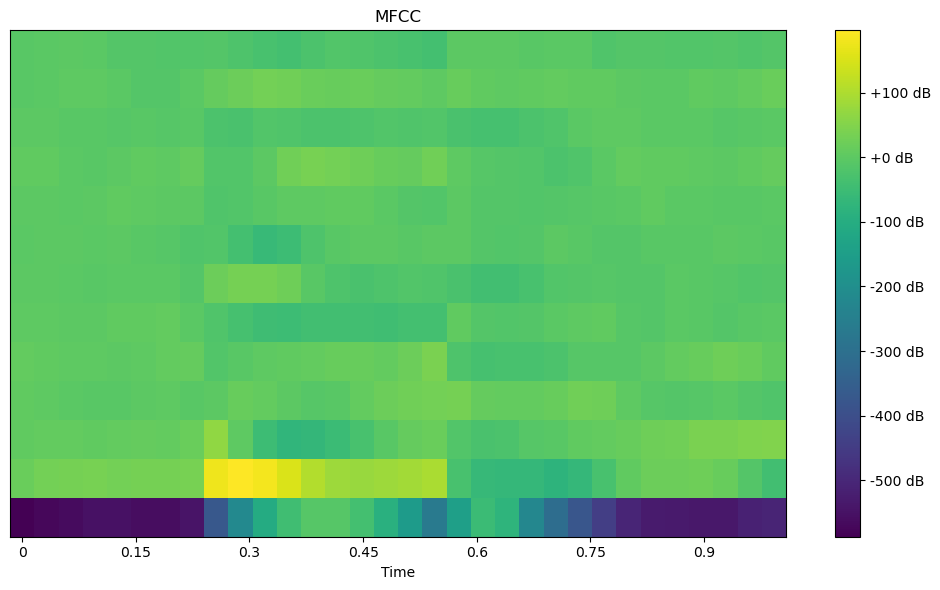

In [17]:
import matplotlib.pyplot as plt
import librosa.display

def plot_mfcc(mfcc, sr):
    """
    Plots the MFCCs as a heatmap.

    Args:
        mfcc (numpy array): The MFCC features.
        sr (int): The sample rate of the audio.
    """
    plt.figure(figsize=(10, 6))
    # Display MFCC as a heatmap
    librosa.display.specshow(mfcc, sr=sr, x_axis='time', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()

# Example usage after extracting MFCC features
file_path = file_paths[0]  # Plot MFCC for the first file in file_paths as an example
audio, sr = load_audio(file_path)
normalized_audio = normalize_audio(audio)
padded_audio = pad_or_trim_audio(normalized_audio, max_length=1.0, sr=sr)
mfcc_features = extract_mfcc(padded_audio, sr, n_mfcc=13, hop_length=512, n_fft=2048)

# Plot the MFCC features
plot_mfcc(mfcc_features, sr)

spitting the dataset

In [29]:
from sklearn.model_selection import train_test_split

def split_data(files, labels, test_size=0.2, val_size=0.2):
    # Split data into training and temp (for validation and test)
    X_train, X_temp, y_train, y_temp = train_test_split(files, labels, test_size=test_size + val_size, random_state=42)
    
    # Split temp data into validation and test
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test
file_paths=[]
labels=[]
# Example usage



X_train, X_val, X_test, y_train, y_val, y_test = split_data(features_list, labels_list)

# Print the results
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))



Training set size: 6603
Validation set size: 2201
Test set size: 2201


saving the data set

In [30]:
import numpy as np

# Function to pad a 2D array (each sub-array)
def pad_array_2d(arr, target_shape):
    padded_arr = np.zeros(target_shape)  # Create an array filled with zeros
    arr = np.array(arr)
    # Copy the content of the original array into the padded array
    padded_arr[:arr.shape[0], :arr.shape[1]] = arr
    return padded_arr

# Find the maximum number of rows and columns
max_rows = max(len(sub_list) for sub_list in features_list)
max_cols = max(len(sub_sub_list) for sub_list in features_list for sub_sub_list in sub_list)

# Pad each sub-array to the maximum rows and columns
features_array = np.array([pad_array_2d(sub_list, (max_rows, max_cols)) for sub_list in features_list])
labels_array = np.array(labels_list)

# Save arrays to .npy files
np.save('train_features.npy', features_array)
np.save('train_labels.npy', labels_array)

print("Data padded and saved successfully.")


Data padded and saved successfully.


# mfcc feature 

In [31]:
import numpy as np

# Load the saved .npy files
features_array = np.load('train_features.npy', allow_pickle=True)
labels_array = np.load('train_labels.npy', allow_pickle=True)

print("Data loaded successfully.")

Data loaded successfully.


# lstm model

In [32]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [60]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/30
138/138 [==============================] - 3s 10ms/step - loss: 3.5112 - accuracy: 0.0498 - val_loss: 3.4632 - val_accuracy: 0.0550
Epoch 2/30
138/138 [==============================] - 1s 7ms/step - loss: 3.3749 - accuracy: 0.0877 - val_loss: 3.4153 - val_accuracy: 0.0731
Epoch 3/30
138/138 [==============================] - 1s 8ms/step - loss: 3.2657 - accuracy: 0.1189 - val_loss: 3.3783 - val_accuracy: 0.0818
Epoch 4/30
138/138 [==============================] - 1s 10ms/step - loss: 3.1323 - accuracy: 0.1546 - val_loss: 3.3635 - val_accuracy: 0.0904
Epoch 5/30
138/138 [==============================] - 2s 11ms/step - loss: 2.9995 - accuracy: 0.1864 - val_loss: 3.3440 - val_accuracy: 0.1059
Epoch 6/30
138/138 [==============================] - 2s 12ms/step - loss: 2.8497 - accuracy: 0.2258 - val_loss: 3.3375 - val_accuracy: 0.1031
Epoch 7/30
138/138 [==============================] - 1s 10ms/step - loss: 2.6925 - accuracy: 0.2634 - val_loss: 3.3434 - val_accuracy: 0.1127
E

# model with single lstm model with learning rate 0.001

In [59]:

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, 
          epochs=20,  # Increased number of epochs for better learning
          batch_size=64, 
          validation_data=(X_test, y_test), 
          callbacks=[early_stopping, reduce_lr])

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/20
138/138 [==============================] - 3s 13ms/step - loss: 4.4239 - accuracy: 0.0312 - val_loss: 4.3569 - val_accuracy: 0.0391 - lr: 5.0000e-05
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 4.3509 - accuracy: 0.0360 - val_loss: 4.3028 - val_accuracy: 0.0441 - lr: 5.0000e-05
Epoch 3/20
138/138 [==============================] - 1s 11ms/step - loss: 4.2897 - accuracy: 0.0396 - val_loss: 4.2536 - val_accuracy: 0.0486 - lr: 5.0000e-05
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 4.2432 - accuracy: 0.0396 - val_loss: 4.2096 - val_accuracy: 0.0445 - lr: 5.0000e-05
Epoch 5/20
138/138 [==============================] - 1s 10ms/step - loss: 4.1945 - accuracy: 0.0423 - val_loss: 4.1685 - val_accuracy: 0.0423 - lr: 5.0000e-05
Epoch 6/20
138/138 [==============================] - 1s 10ms/step - loss: 4.1501 - accuracy: 0.0459 - val_loss: 4.1299 - val_accuracy: 0.0441 - lr: 5.0000e-05
Epoch 7/20
138/138 [====================

In [47]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Make predictions
predictions = model.predict(X_test)
predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
print(predicted_labels)

69/69 [==============================] - 0s 4ms/step - loss: 3.7414 - accuracy: 0.0945
Test Loss: 3.741359233856201
Test Accuracy: 0.09450250118970871
69/69 [==============================] - 1s 3ms/step
['four' 'down' 'happy' ... 'seven' 'right' 'off']


In [66]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define LSTM Model
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model with custom learning rate
initial_learning_rate = 0.001
optimizer = Adam(learning_rate=initial_learning_rate)  # Set custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Reduce learning rate if the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/20
138/138 [==============================] - 3s 10ms/step - loss: 4.0595 - accuracy: 0.0461 - val_loss: 3.7787 - val_accuracy: 0.0554 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 1s 10ms/step - loss: 3.6359 - accuracy: 0.0679 - val_loss: 3.5652 - val_accuracy: 0.0686 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 1s 9ms/step - loss: 3.4850 - accuracy: 0.0875 - val_loss: 3.4846 - val_accuracy: 0.0713 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 1s 10ms/step - loss: 3.4018 - accuracy: 0.1009 - val_loss: 3.4347 - val_accuracy: 0.0791 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 1s 10ms/step - loss: 3.3374 - accuracy: 0.1170 - val_loss: 3.4053 - val_accuracy: 0.0963 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 1s 9ms/step - loss: 3.2711 - accuracy: 0.1315 - val_loss: 3.3800 - val_accuracy: 0.0931 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 1s 10ms/step

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# gru model
GRU (Gated Recurrent Unit)
GRUs are a simplified version of LSTMs. 
They have fewer gates and are computationally more efficient,
but often achieve similar performance in sequence modeling 

In [70]:
from tensorflow.keras.layers import GRU

# Define GRU Model
model = Sequential()
model.add(GRU(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

Epoch 1/10
138/138 [==============================] - 2s 9ms/step - loss: 4.2345 - accuracy: 0.0435 - val_loss: 3.9606 - val_accuracy: 0.0459
Epoch 2/10
138/138 [==============================] - 1s 7ms/step - loss: 3.8089 - accuracy: 0.0612 - val_loss: 3.7140 - val_accuracy: 0.0572
Epoch 3/10
138/138 [==============================] - 1s 8ms/step - loss: 3.6033 - accuracy: 0.0746 - val_loss: 3.5823 - val_accuracy: 0.0672
Epoch 4/10
138/138 [==============================] - 1s 9ms/step - loss: 3.4864 - accuracy: 0.0885 - val_loss: 3.5216 - val_accuracy: 0.0704
Epoch 5/10
138/138 [==============================] - 1s 8ms/step - loss: 3.4106 - accuracy: 0.1056 - val_loss: 3.4801 - val_accuracy: 0.0731
Epoch 6/10
138/138 [==============================] - 1s 8ms/step - loss: 3.3485 - accuracy: 0.1149 - val_loss: 3.4513 - val_accuracy: 0.0877
Epoch 7/10
138/138 [==============================] - 1s 8ms/step - loss: 3.2945 - accuracy: 0.1273 - val_loss: 3.4215 - val_accuracy: 0.0954
Epoch 

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# one layer bidirectional lstm model

In [71]:
from tensorflow.keras.layers import Bidirectional, LSTM

# Define Bidirectional LSTM Model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

Epoch 1/10
138/138 [==============================] - 5s 19ms/step - loss: 4.0700 - accuracy: 0.0467 - val_loss: 3.7031 - val_accuracy: 0.0772
Epoch 2/10
138/138 [==============================] - 2s 15ms/step - loss: 3.5526 - accuracy: 0.0972 - val_loss: 3.4162 - val_accuracy: 0.1304
Epoch 3/10
138/138 [==============================] - 2s 15ms/step - loss: 3.3337 - accuracy: 0.1290 - val_loss: 3.2725 - val_accuracy: 0.1390
Epoch 4/10
138/138 [==============================] - 2s 16ms/step - loss: 3.1933 - accuracy: 0.1594 - val_loss: 3.1815 - val_accuracy: 0.1790
Epoch 5/10
138/138 [==============================] - 2s 16ms/step - loss: 3.0860 - accuracy: 0.1929 - val_loss: 3.0871 - val_accuracy: 0.1890
Epoch 6/10
138/138 [==============================] - 2s 15ms/step - loss: 2.9901 - accuracy: 0.2106 - val_loss: 3.0308 - val_accuracy: 0.1999
Epoch 7/10
138/138 [==============================] - 2s 16ms/step - loss: 2.9020 - accuracy: 0.2293 - val_loss: 3.0144 - val_accuracy: 0.2072

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# stack layed lstm

In [73]:
# Define Stacked LSTM Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))  # Second LSTM layer
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

Epoch 1/10
138/138 [==============================] - 5s 23ms/step - loss: 3.8449 - accuracy: 0.0425 - val_loss: 3.6010 - val_accuracy: 0.0513
Epoch 2/10
138/138 [==============================] - 3s 20ms/step - loss: 3.4919 - accuracy: 0.0764 - val_loss: 3.3759 - val_accuracy: 0.0850
Epoch 3/10
138/138 [==============================] - 3s 20ms/step - loss: 3.2725 - accuracy: 0.1237 - val_loss: 3.1169 - val_accuracy: 0.1604
Epoch 4/10
138/138 [==============================] - 3s 20ms/step - loss: 3.0810 - accuracy: 0.1647 - val_loss: 2.9864 - val_accuracy: 0.1817
Epoch 5/10
138/138 [==============================] - 3s 19ms/step - loss: 2.9392 - accuracy: 0.2001 - val_loss: 2.9136 - val_accuracy: 0.1940
Epoch 6/10
138/138 [==============================] - 3s 20ms/step - loss: 2.8238 - accuracy: 0.2182 - val_loss: 2.7976 - val_accuracy: 0.2213
Epoch 7/10
138/138 [==============================] - 3s 21ms/step - loss: 2.7347 - accuracy: 0.2357 - val_loss: 2.7177 - val_accuracy: 0.2508

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# bidirectional gru model

In [74]:
# Define Bidirectional GRU Model
model = Sequential()
model.add(Bidirectional(GRU(128, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/10
138/138 [==============================] - 4s 15ms/step - loss: 4.3087 - accuracy: 0.0519 - val_loss: 3.9502 - val_accuracy: 0.0709
Epoch 2/10
138/138 [==============================] - 2s 12ms/step - loss: 3.7200 - accuracy: 0.0937 - val_loss: 3.5169 - val_accuracy: 0.1077
Epoch 3/10
138/138 [==============================] - 2s 13ms/step - loss: 3.3715 - accuracy: 0.1411 - val_loss: 3.2827 - val_accuracy: 0.1449
Epoch 4/10
138/138 [==============================] - 2s 14ms/step - loss: 3.1687 - accuracy: 0.1765 - val_loss: 3.1642 - val_accuracy: 0.1795
Epoch 5/10
138/138 [==============================] - 2s 14ms/step - loss: 3.0570 - accuracy: 0.2010 - val_loss: 3.0834 - val_accuracy: 0.1895
Epoch 6/10
138/138 [==============================] - 2s 14ms/step - loss: 2.9529 - accuracy: 0.2185 - val_loss: 3.0310 - val_accuracy: 0.1999
Epoch 7/10
138/138 [==============================] - 2s 13ms/step - loss: 2.8787 - accuracy: 0.2385 - val_loss: 3.0106 - val_accuracy: 0.2154

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# stack lstm 3 layer lstm

In [75]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Stacked LSTM Model with 3 layers
model = Sequential()

# First LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Third LSTM layer with return_sequences=False (final LSTM layer)
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))  # Add dropout

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20,  # You can increase this if needed
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/20
138/138 [==============================] - 6s 21ms/step - loss: 3.7412 - accuracy: 0.0399 - val_loss: 3.5742 - val_accuracy: 0.0645 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 2s 16ms/step - loss: 3.4711 - accuracy: 0.0743 - val_loss: 3.3342 - val_accuracy: 0.0963 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 2s 17ms/step - loss: 3.2726 - accuracy: 0.1075 - val_loss: 3.1769 - val_accuracy: 0.1245 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 3s 19ms/step - loss: 3.1397 - accuracy: 0.1332 - val_loss: 3.0541 - val_accuracy: 0.1490 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 3s 19ms/step - loss: 3.0376 - accuracy: 0.1605 - val_loss: 3.0117 - val_accuracy: 0.1495 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 3s 18ms/step - loss: 2.9477 - accuracy: 0.1791 - val_loss: 2.8730 - val_accuracy: 0.1976 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 3s 19ms/st

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# 5 layer lstm model adam optimizer initial learning rate 0.001

In [76]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Stacked LSTM Model with 5 layers
model = Sequential()

# First LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second LSTM layer with return_sequences=True
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Third LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Fourth LSTM layer with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))  # Add dropout

# Fifth LSTM layer with return_sequences=False (final LSTM layer)
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))  # Add dropout

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=20,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



Epoch 1/20
138/138 [==============================] - 12s 47ms/step - loss: 3.7196 - accuracy: 0.0462 - val_loss: 3.5323 - val_accuracy: 0.0600 - lr: 0.0010
Epoch 2/20
138/138 [==============================] - 5s 37ms/step - loss: 3.4626 - accuracy: 0.0750 - val_loss: 3.3823 - val_accuracy: 0.0736 - lr: 0.0010
Epoch 3/20
138/138 [==============================] - 5s 40ms/step - loss: 3.3506 - accuracy: 0.0826 - val_loss: 3.2994 - val_accuracy: 0.0945 - lr: 0.0010
Epoch 4/20
138/138 [==============================] - 6s 41ms/step - loss: 3.2596 - accuracy: 0.1015 - val_loss: 3.2214 - val_accuracy: 0.1059 - lr: 0.0010
Epoch 5/20
138/138 [==============================] - 6s 40ms/step - loss: 3.1795 - accuracy: 0.1265 - val_loss: 3.1103 - val_accuracy: 0.1458 - lr: 0.0010
Epoch 6/20
138/138 [==============================] - 6s 42ms/step - loss: 3.0963 - accuracy: 0.1395 - val_loss: 3.0217 - val_accuracy: 0.1549 - lr: 0.0010
Epoch 7/20
138/138 [==============================] - 6s 42ms/s

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


# bidirectional and stack lstm model

In [2]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define Stacked LSTM Model with Bidirectional LSTMs
model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second LSTM layer (not bidirectional) with return_sequences=True
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))

# Third Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

# Fourth LSTM layer (not bidirectional) with return_sequences=True
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.3))

# Fifth LSTM layer (not bidirectional) with return_sequences=False
model.add(LSTM(32, return_sequences=False))
model.add(Dropout(0.3))

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
#early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
# Train the model
history = model.fit(X_train, y_train, 
                    epochs=100,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



Epoch 1/100
138/138 [==============================] - 43s 182ms/step - loss: 3.7274 - accuracy: 0.0471 - val_loss: 3.5508 - val_accuracy: 0.0691
Epoch 2/100
138/138 [==============================] - 18s 127ms/step - loss: 3.4324 - accuracy: 0.0801 - val_loss: 3.3272 - val_accuracy: 0.0900
Epoch 3/100
138/138 [==============================] - 24s 170ms/step - loss: 3.2367 - accuracy: 0.1067 - val_loss: 3.2043 - val_accuracy: 0.1163
Epoch 4/100
138/138 [==============================] - 18s 130ms/step - loss: 3.1248 - accuracy: 0.1287 - val_loss: 3.0886 - val_accuracy: 0.1308
Epoch 5/100
138/138 [==============================] - 20s 144ms/step - loss: 3.0389 - accuracy: 0.1478 - val_loss: 3.0091 - val_accuracy: 0.1436
Epoch 6/100
138/138 [==============================] - 18s 133ms/step - loss: 2.9450 - accuracy: 0.1629 - val_loss: 2.9317 - val_accuracy: 0.1731
Epoch 7/100
138/138 [==============================] - 21s 149ms/step - loss: 2.8631 - accuracy: 0.1845 - val_loss: 2.8618 -

Epoch 57/100
138/138 [==============================] - 26s 188ms/step - loss: 0.8131 - accuracy: 0.7785 - val_loss: 1.9669 - val_accuracy: 0.5547
Epoch 58/100
138/138 [==============================] - 20s 144ms/step - loss: 0.7867 - accuracy: 0.7819 - val_loss: 2.0074 - val_accuracy: 0.5529
Epoch 59/100
138/138 [==============================] - 22s 158ms/step - loss: 0.7569 - accuracy: 0.7913 - val_loss: 1.9917 - val_accuracy: 0.5652
Epoch 60/100
138/138 [==============================] - 23s 165ms/step - loss: 0.7513 - accuracy: 0.7960 - val_loss: 2.0045 - val_accuracy: 0.5543
Epoch 61/100
138/138 [==============================] - 20s 146ms/step - loss: 0.7535 - accuracy: 0.7965 - val_loss: 1.9570 - val_accuracy: 0.5579
Epoch 62/100
138/138 [==============================] - 25s 184ms/step - loss: 0.7575 - accuracy: 0.7913 - val_loss: 2.0118 - val_accuracy: 0.5738
Epoch 63/100
138/138 [==============================] - 18s 128ms/step - loss: 0.7207 - accuracy: 0.8028 - val_loss: 2

In [33]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,) 

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define a 3-layer Bidirectional LSTM model
model = Sequential()

# First Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))  # Add dropout to reduce overfitting

# Second Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.3))

# Third Bidirectional LSTM layer with return_sequences=False (for the final output layer)
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dropout(0.3))

# Add dense layers
model.add(Dense(64, activation='relu', kernel_regularizer='l2'))  # Add L2 regularization
model.add(Dense(y_train.shape[1], activation='softmax'))  # Output layer

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Define optimizer with custom learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and learning rate reduction
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=100,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test))

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/100
 19/138 [===>..........................] - ETA: 3:17 - loss: 4.3055 - accuracy: 0.0387

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='best')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='best')

plt.tight_layout()
plt.show()


In [4]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [5]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


# hmm model

In [61]:

from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import LabelEncoder

# Preprocess the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels_array.flatten())  # Convert string labels to numeric form

# Reshape feature array for HMM - It expects 2D input (samples, features)
X_reshaped = features_array.reshape(-1, features_array.shape[2])  # Shape (11005 * 13, 32)

# Initialize Gaussian HMM
hmm_model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=100)

# Fit HMM to the data
hmm_model.fit(X_reshaped)

# Predict on the training data
hidden_states = hmm_model.predict(X_reshaped)
print("Hidden states predicted by HMM:", hidden_states)







Hidden states predicted by HMM: [1 3 3 ... 0 0 0]


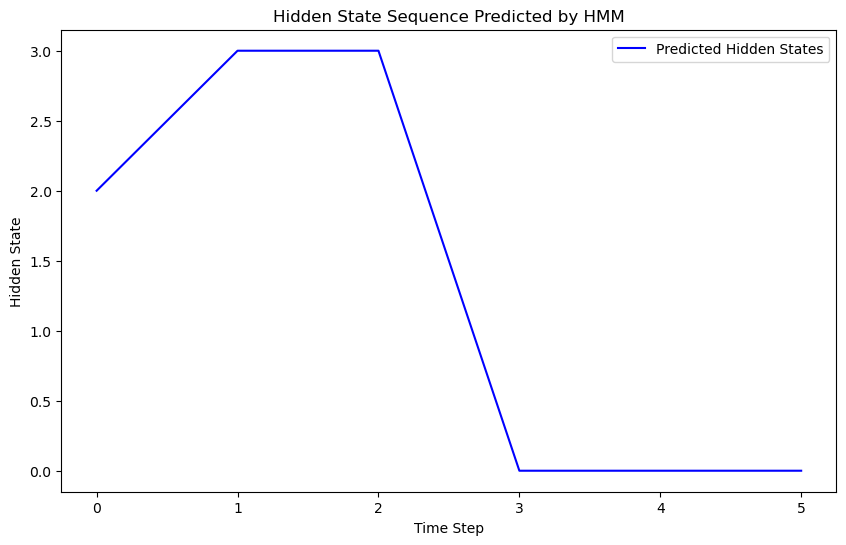

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Example of correct hidden_states array (replace with your actual array)
hidden_states = np.array([2, 3, 3, 0, 0, 0])  # Ensure no ellipsis here

# Plot the hidden states over time
plt.figure(figsize=(10, 6))
plt.plot(hidden_states, label="Predicted Hidden States", color="blue")
plt.title("Hidden State Sequence Predicted by HMM")
plt.xlabel("Time Step")
plt.ylabel("Hidden State")
plt.legend()
plt.show()


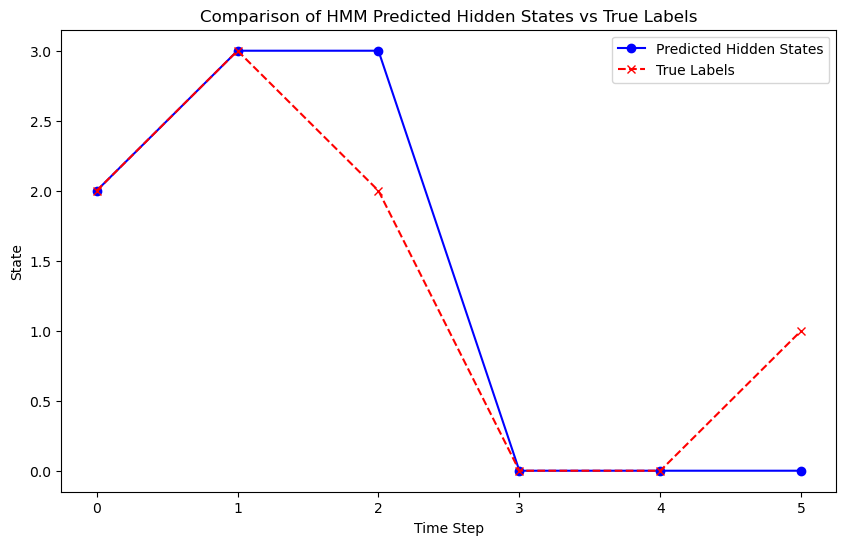

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have these arrays already:
# Replace these with your actual arrays
hidden_states = np.array([2, 3, 3, 0, 0, 0])  # HMM predicted hidden states
y_true = np.array([2, 3, 2, 0, 0, 1])        # True labels

# Ensure they are of the same length
assert len(hidden_states) == len(y_true), "Lengths of predicted and true labels must match!"

# Plot the comparison
plt.figure(figsize=(10, 6))

# Plot the hidden states predicted by HMM
plt.plot(hidden_states, label="Predicted Hidden States", color="blue", marker='o')

# Plot the true labels
plt.plot(y_true, label="True Labels", color="red", linestyle='--', marker='x')

plt.title("Comparison of HMM Predicted Hidden States vs True Labels")
plt.xlabel("Time Step")
plt.ylabel("State")
plt.legend()
plt.show()


# Convolutional Neural Networks (CNNs) for Time-Series

In [14]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

# Define CNN model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# Add more Conv1D layers or transition to Dense layers
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, 
                    epochs=30,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')

Epoch 1/30
138/138 [==============================] - 1s 5ms/step - loss: 13.0929 - accuracy: 0.0420 - val_loss: 3.5420 - val_accuracy: 0.0377
Epoch 2/30
138/138 [==============================] - 0s 3ms/step - loss: 3.5878 - accuracy: 0.0382 - val_loss: 3.5285 - val_accuracy: 0.0377
Epoch 3/30
138/138 [==============================] - 1s 4ms/step - loss: 3.5478 - accuracy: 0.0361 - val_loss: 3.5174 - val_accuracy: 0.0377
Epoch 4/30
138/138 [==============================] - 0s 4ms/step - loss: 3.5192 - accuracy: 0.0398 - val_loss: 3.4969 - val_accuracy: 0.0477
Epoch 5/30
138/138 [==============================] - 0s 4ms/step - loss: 3.4905 - accuracy: 0.0483 - val_loss: 3.4653 - val_accuracy: 0.0495
Epoch 6/30
138/138 [==============================] - 1s 4ms/step - loss: 3.4682 - accuracy: 0.0521 - val_loss: 3.4399 - val_accuracy: 0.0582
Epoch 7/30
138/138 [==============================] - 1s 4ms/step - loss: 3.4382 - accuracy: 0.0578 - val_loss: 3.4179 - val_accuracy: 0.0541
Epoch

#  CNN + LSTM hybrid model

In [20]:
# Define CNN + LSTM hybrid model
model = Sequential()

# CNN part
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM part
model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.3))

# Dense layers
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile and train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, 
                    epochs=30,  # Increase if necessary
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')



Epoch 1/30
138/138 [==============================] - 4s 12ms/step - loss: 3.5272 - accuracy: 0.0444 - val_loss: 3.4544 - val_accuracy: 0.0672
Epoch 2/30
138/138 [==============================] - 1s 9ms/step - loss: 3.4477 - accuracy: 0.0579 - val_loss: 3.3850 - val_accuracy: 0.0845
Epoch 3/30
138/138 [==============================] - 1s 8ms/step - loss: 3.3958 - accuracy: 0.0691 - val_loss: 3.3315 - val_accuracy: 0.0804
Epoch 4/30
138/138 [==============================] - 1s 8ms/step - loss: 3.3519 - accuracy: 0.0799 - val_loss: 3.2875 - val_accuracy: 0.0977
Epoch 5/30
138/138 [==============================] - 1s 8ms/step - loss: 3.3182 - accuracy: 0.0881 - val_loss: 3.2479 - val_accuracy: 0.1050
Epoch 6/30
138/138 [==============================] - 1s 8ms/step - loss: 3.2745 - accuracy: 0.0972 - val_loss: 3.1839 - val_accuracy: 0.1199
Epoch 7/30
138/138 [==============================] - 1s 9ms/step - loss: 3.2291 - accuracy: 0.1010 - val_loss: 3.1697 - val_accuracy: 0.1222
Epoch

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Bidirectional, LSTM, Dense

# Initialize the model
model = Sequential()

# CNN part with 2 Conv1D layers
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))  # 2nd CNN layer
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# LSTM part with 2 Bidirectional LSTM layers
model.add(Bidirectional(LSTM(128, return_sequences=True)))  # First Bidirectional LSTM layer
model.add(Dropout(0.3))

model.add(Bidirectional(LSTM(64, return_sequences=False)))  # Second Bidirectional LSTM layer
model.add(Dropout(0.3))

# Dense layers for final classification
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='softmax'))

# Compile and train the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=30,  # Adjust as needed
                    batch_size=64, 
                    validation_data=(X_test, y_test),
                    )

# Evaluate the model
score = model.evaluate(X_test, y_test)
print(f'Test Loss: {score[0]}, Test Accuracy: {score[1]}')


Epoch 1/30
138/138 [==============================] - 16s 42ms/step - loss: 3.5157 - accuracy: 0.0351 - val_loss: 3.4843 - val_accuracy: 0.0423
Epoch 2/30
138/138 [==============================] - 2s 16ms/step - loss: 3.4948 - accuracy: 0.0394 - val_loss: 3.4765 - val_accuracy: 0.0463
Epoch 3/30
138/138 [==============================] - 3s 22ms/step - loss: 3.4836 - accuracy: 0.0448 - val_loss: 3.4191 - val_accuracy: 0.0695
Epoch 4/30
138/138 [==============================] - 3s 22ms/step - loss: 3.4106 - accuracy: 0.0534 - val_loss: 3.2836 - val_accuracy: 0.0727
Epoch 5/30
138/138 [==============================] - 3s 19ms/step - loss: 3.3337 - accuracy: 0.0644 - val_loss: 3.2435 - val_accuracy: 0.0781
Epoch 6/30
138/138 [==============================] - 3s 22ms/step - loss: 3.2758 - accuracy: 0.0783 - val_loss: 3.1908 - val_accuracy: 0.0827
Epoch 7/30
138/138 [==============================] - 3s 20ms/step - loss: 3.2543 - accuracy: 0.0799 - val_loss: 3.1575 - val_accuracy: 0.091

In [8]:
pip install sounddevice numpy


  Obtaining dependency information for sounddevice from https://files.pythonhosted.org/packages/bf/2a/58fa1704b5cf8041564337674790426d39d630e7407e54e17a1212332959/sounddevice-0.5.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/189.8 kB ? eta -:--:--
   ---------------------------------------- 189.8/189.8 kB 5.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import sounddevice as sd
import numpy as np
import wave

# Function to record audio
def record_audio(filename, duration, fs=16000):
    print(f"Recording for {duration} seconds...")
    audio_data = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='int16')
    sd.wait()  # Wait until recording is finished
    print("Recording complete.")
    
    # Save the recording as a WAV file
    with wave.open(filename, 'wb') as wf:
        wf.setnchannels(1)  # Mono
        wf.setsampwidth(2)  # 16 bits
        wf.setframerate(fs)
        wf.writeframes(audio_data.tobytes())

# Example usage
keywords = ['हाँ', 'नहीं', 'रुको', 'जाओ']  # Hindi keywords
duration = 2  # Duration for each recording in seconds

for keyword in keywords:
    filename = f"{keyword}.wav"  # Filename based on the keyword
    record_audio(filename, duration)


Recording for 2 seconds...
Recording complete.
Recording for 2 seconds...
Recording complete.
Recording for 2 seconds...
Recording complete.
Recording for 2 seconds...
Recording complete.


In [19]:
pip install --upgrade pip setuptools

  Obtaining dependency information for pip from https://files.pythonhosted.org/packages/d4/55/90db48d85f7689ec6f81c0db0622d704306c5284850383c090e6c7195a5c/pip-24.2-py3-none-any.whl.metadata
  Using cached pip-24.2-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for setuptools from https://files.pythonhosted.org/packages/ff/ae/f19306b5a221f6a436d8f2238d5b80925004093fa3edea59835b514d9057/setuptools-75.1.0-py3-none-any.whl.metadata
  Using cached setuptools-75.1.0-py3-none-any.whl.metadata (6.9 kB)
Using cached pip-24.2-py3-none-any.whl (1.8 MB)
Using cached setuptools-75.1.0-py3-none-any.whl (1.2 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.0.0
    Uninstalling setuptools-68.0.0:
      Successfully uninstalled setuptools-68.0.0
  Attempting uninstall: pip
    Found existing installation: pip 23.2.1
    Uninstalling pip-23.2.1:
      Successfully uninstalled pip-23.2.1
Note: you may need to restart the kernel to use updated pa

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.41 requires requests_mock, which is not installed.
conda-repo-cli 1.0.41 requires clyent==1.2.1, but you have clyent 1.2.2 which is incompatible.
conda-repo-cli 1.0.41 requires nbformat==5.4.0, but you have nbformat 5.7.0 which is incompatible.
conda-repo-cli 1.0.41 requires requests==2.28.1, but you have requests 2.31.0 which is incompatible.
tensorflow-intel 2.14.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 5.28.2 which is incompatible.


In [20]:
pip install cython numpy


   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ----------- ---------------------------- 0.8/2.8 MB 8.3 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.


In [23]:
pip install TTS --no-cache-dir


     ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
     ------------------- -------------------- 0.8/1.7 MB 11.2 MB/s eta 0:00:01
     ---------------------------------------- 1.7/1.7 MB 15.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ---------------------------------------- 0.0/19.2 MB ? eta -:--:--
     ---------- ----------------------------- 5.2/19.2 MB 26.5 MB/s eta 0:00:01
     ------------------- -------------------- 9.4/19.2 MB 23.5 MB/s eta 0:00:01
     ---------------------------- ---------- 13.9/19.2 MB 22.3 MB/s eta 0:00:01
     ---------------------------------- ---- 17.0/19.2 MB 21.1 MB/s eta 0:00:01
     --------------------------------------- 19.2

  error: subprocess-exited-with-error
  
  python setup.py egg_info did not run successfully.
  exit code: 1
  
  [1 lines of output]
  ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

Encountered error while generating package metadata.

See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [26]:
pip install gTTS


Note: you may need to restart the kernel to use updated packages.


In [28]:
# Import the required module for text 
# to speech conversion
from gtts import gTTS

# This module is imported so that we can 
# play the converted audio
import os

# The text that you want to convert to audio in Hindi
mytext = 'स्वागत है आप सभी का!'

# Language in which you want to convert (Hindi)
language = 'hi'

# Passing the text and language to the engine, 
# here we have marked slow=False. Which tells 
# the module that the converted audio should 
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)

# Saving the converted audio in a mp3 file named
# welcome 
myobj.save("welcome_hindi.mp3")

# Playing the converted file
os.system("start welcome_hindi.mp3")  # For Windows
# Use 'afplay' for macOS or 'xdg-open' for Linux


0

In [22]:
from TTS.api import TTS

# Load the TTS model for Hindi
tts = TTS(model_name="tts_models/hi-IN/datakey")  # Replace with the correct model name

# Generate speech
tts.tts_to_file(text="नमस्ते, आप कैसे हैं?", file_path="yes.wav")


ModuleNotFoundError: No module named 'TTS.api'

In [13]:
from google.cloud import texttospeech

# Create a client
client = texttospeech.TextToSpeechClient()

# Set the text input to be synthesized
text_input = texttospeech.SynthesisInput(text='हाँ')  # "Yes" in Hindi

# Build the voice request
voice = texttospeech.VoiceSelectionParams(
    language_code="hi-IN",  # Hindi language code
    ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL,
)

# Select the type of audio file
audio_config = texttospeech.AudioConfig(
    audio_encoding=texttospeech.AudioEncoding.MP3,
)

# Perform the text-to-speech request
response = client.synthesize_speech(input=text_input, voice=voice, audio_config=audio_config)

# Write the response to the output file
with open('yes_hindi.mp3', 'wb') as out:
    out.write(response.audio_content)


SyntaxError: invalid syntax (2324358556.py, line 1)

# natural optimization model

# Particle Swarm Optimization (PSO) with PySwarms

In [10]:
def create_model():
    
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model


In [11]:
def get_number_of_params(model):
    return np.sum([np.prod(var.shape) for var in model.trainable_variables])


In [12]:
def flatten_weights(weights):
    return np.concatenate([w.flatten() for w in weights])


In [13]:
def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.trainable_variables]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    weights = [flattened_weights[indices[i]:indices[i+1]].reshape(shape) for i, shape in enumerate(shapes)]
    return weights


In [14]:

def fitness_func(params):
    model = create_model()
    weights = unflatten_weights(params, model)
    model.set_weights(weights)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy  # PSO minimizes the objective function


In [39]:
pip install pyswarms


Note: you may need to restart the kernel to use updated packages.


In [17]:
import numpy as np
import pyswarms as ps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.optimizers import Adam

# Define model architecture
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

# Flatten and unflatten functions
def flatten_weights(model):
    return np.concatenate([w.flatten() for w in model.get_weights()])

def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.get_weights()]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    weights = []
    for i, shape in enumerate(shapes):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        weight_shape = flattened_weights[start_idx:end_idx].shape
        print(f"Shape of flat weights slice for layer {i}: {weight_shape}, expected shape: {shape}")
        weights.append(flattened_weights[start_idx:end_idx].reshape(shape))
    return weights

# Define the fitness function
def fitness_func(params):
    model = create_model()
    weights = unflatten_weights(params, model)
    model.set_weights(weights)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy  # PSO minimizes the objective function

# Define PSO parameters
n_params = get_number_of_params(create_model())
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

# Initialize and run PSO
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)
cost, pos = optimizer.optimize(fitness_func, iters=10)


2024-09-15 15:18:23,881 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10

Shape of flat weights slice for layer 0: (10, 527011), expected shape: (32, 512)


ValueError: cannot reshape array of size 5270110 into shape (32,512)

In [18]:
def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer='l2'))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    return model

def print_weights_info(model):
    weights = model.get_weights()
    for i, weight in enumerate(weights):
        print(f"Layer {i} weights shape: {weight.shape}")

model = create_model()
print_weights_info(model)


Layer 0 weights shape: (32, 512)
Layer 1 weights shape: (128, 512)
Layer 2 weights shape: (512,)
Layer 3 weights shape: (32, 512)
Layer 4 weights shape: (128, 512)
Layer 5 weights shape: (512,)
Layer 6 weights shape: (256, 512)
Layer 7 weights shape: (128, 512)
Layer 8 weights shape: (512,)
Layer 9 weights shape: (128, 256)
Layer 10 weights shape: (64, 256)
Layer 11 weights shape: (256,)
Layer 12 weights shape: (128, 256)
Layer 13 weights shape: (64, 256)
Layer 14 weights shape: (256,)
Layer 15 weights shape: (128, 256)
Layer 16 weights shape: (64, 256)
Layer 17 weights shape: (256,)
Layer 18 weights shape: (64, 128)
Layer 19 weights shape: (32, 128)
Layer 20 weights shape: (128,)
Layer 21 weights shape: (32, 64)
Layer 22 weights shape: (64,)
Layer 23 weights shape: (64, 35)
Layer 24 weights shape: (35,)


In [19]:
def get_number_of_params(model):
    return np.sum([np.prod(var.shape) for var in model.get_weights()])

n_params = get_number_of_params(create_model())
print("Total number of parameters:", n_params)


Total number of parameters: 527011


In [20]:
def flatten_weights(model):
    return np.concatenate([w.flatten() for w in model.get_weights()])


In [21]:
def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.get_weights()]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    
    weights = []
    for i, shape in enumerate(shapes):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        flattened_slice = flattened_weights[start_idx:end_idx]
        if np.prod(shape) != len(flattened_slice):
            raise ValueError(f"Shape mismatch: expected {np.prod(shape)}, got {len(flattened_slice)}")
        weights.append(flattened_slice.reshape(shape))
    
    return weights


In [22]:
def fitness_func(params):
    model = create_model()
    weights = unflatten_weights(params, model)
    model.set_weights(weights)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
    accuracy = history.history['val_accuracy'][-1]
    return -accuracy  # PSO minimizes the objective function

# Check dimensions
n_params = get_number_of_params(create_model())
print("Number of parameters:", n_params)

# Initialize and run PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)
cost, pos = optimizer.optimize(fitness_func, iters=10)


Number of parameters: 527011


2024-09-15 15:20:04,060 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10


ValueError: Shape mismatch: expected 16384, got 10

In [23]:
def unflatten_weights(flattened_weights, model):
    shapes = [var.shape for var in model.get_weights()]
    indices = np.cumsum([np.prod(shape) for shape in shapes])[:-1]
    indices = np.concatenate(([0], indices))
    
    weights = []
    for i, shape in enumerate(shapes):
        start_idx = indices[i]
        end_idx = indices[i + 1]
        flattened_slice = flattened_weights[start_idx:end_idx]
        print(f"Layer {i} shape: {shape}, flattened_slice shape: {flattened_slice.shape}")
        if np.prod(shape) != len(flattened_slice):
            raise ValueError(f"Shape mismatch: expected {np.prod(shape)}, got {len(flattened_slice)}")
        weights.append(flattened_slice.reshape(shape))
    
    return weights


In [24]:
def get_model_params(model):
    shapes = [w.shape for w in model.get_weights()]
    total_params = np.sum([np.prod(shape) for shape in shapes])
    return shapes, total_params

model = create_model()
shapes, total_params = get_model_params(model)
print("Model parameters shapes:", shapes)
print("Total number of parameters:", total_params)


Model parameters shapes: [(32, 512), (128, 512), (512,), (32, 512), (128, 512), (512,), (256, 512), (128, 512), (512,), (128, 256), (64, 256), (256,), (128, 256), (64, 256), (256,), (128, 256), (64, 256), (256,), (64, 128), (32, 128), (128,), (32, 64), (64,), (64, 35), (35,)]
Total number of parameters: 527011


In [25]:
def fitness_func(params):
    model = create_model()
    try:
        weights = unflatten_weights(params, model)
        model.set_weights(weights)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test), verbose=0)
        accuracy = history.history['val_accuracy'][-1]
        return -accuracy  # PSO minimizes the objective function
    except ValueError as e:
        print(f"ValueError in fitness function: {e}")
        return np.inf  # Return a high cost if there's an error


In [26]:
n_params = total_params  # Ensure this matches the number of parameters in your model
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)


In [27]:
import pyswarms as ps

# Example dimensions for PSO
n_params = total_params  # Ensure this matches the number of parameters in your model

# Initialize and run PSO
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)
cost, pos = optimizer.optimize(fitness_func, iters=10)


2024-09-15 15:22:17,254 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10, best_cost=inf

Layer 0 shape: (32, 512), flattened_slice shape: (10, 527011)
ValueError in fitness function: Shape mismatch: expected 16384, got 10


ValueError: operands could not be broadcast together with shapes (0,) (10,527011) 

ValueError: cannot reshape array of size 3662464 into shape (784)

In [38]:
import numpy as np
from pyswarm import pso
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess your data
# Assume feature_array and labels_array are already loaded
X = feature_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the function to optimize
def objective_function(params):
    # Unpack parameters
    units_layer1, units_layer2, learning_rate = int(params[0]), int(params[1]), params[2]
    
    # Build model
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(units_layer2, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    
    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return -accuracy  # We minimize the negative accuracy to maximize accuracy

# Define the bounds for each parameter
lb = [32, 32, 1e-5]  # lower bounds for [units_layer1, units_layer2, learning_rate]
ub = [128, 128, 1e-1]  # upper bounds for [units_layer1, units_layer2, learning_rate]

# Run PSO
best_params, best_score = pso(objective_function, lb, ub, swarmsize=20, maxiter=10, debug=True)

print("Best Parameters:", best_params)
print("Best Score (negative accuracy):", best_score)


ModuleNotFoundError: No module named 'pyswarm'

In [40]:
import numpy as np
import pyswarms as ps
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Assuming you have your feature_array and labels_array ready
X = features_array  # Shape (11005, 13, 32)
y = labels_array   # Shape (11005,)

# Reshape y to 2D array (11005, 1) to work with OneHotEncoder
y = y.reshape(-1, 1)

# One-hot encode the labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(y).toarray()

# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)



n_params = get_number_of_params(create_model())  # Total number of parameters
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

optimizer = ps.single.GlobalBestPSO(n_particles=10, dimensions=n_params, options=options)

# Run the PSO
cost, pos = optimizer.optimize(fitness_func, iters=10)



2024-09-15 15:34:59,681 - pyswarms.single.global_best - INFO - Optimize for 10 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/10, best_cost=inf

ValueError in fitness function: Shape mismatch: expected 212992, got 10


ValueError: operands could not be broadcast together with shapes (0,) (10,494115) 

In [41]:
pip install deap


     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     - -------------------------------------- 0.0/1.1 MB 991.0 kB/s eta 0:00:02
     -- ------------------------------------- 0.1/1.1 MB 787.7 kB/s eta 0:00:02
     ----- ---------------------------------- 0.1/1.1 MB 1.1 MB/s eta 0:00:01
     ------ --------------------------------- 0.2/1.1 MB 984.6 kB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.1 MB 935.2 kB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.1 MB 860.2 kB/s eta 0:00:01
     -------- ------------------------------- 0.2/1.1 MB 860.2 kB/s eta 0:00:01
     ----------- ---------------------------- 0.3/1.1 MB 764.6 kB/s eta 0:00:02
     ------------- -------------------------- 0.3/1.1 MB 800.8 kB/s eta 0:00:01
     -------------- ------------------------- 0.4/1.1 MB 786.0 kB/s eta 0:00:01
     ---------------- ----------------------- 0.4/1.1 MB 813.6 kB/s eta 0:00:01
     ---------------- ----------------------- 0.4/1

In [44]:
import numpy as np
import tensorflow as tf
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load and preprocess your data
X = features_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the evaluation function
def evaluate(individual):
    units_layer1, units_layer2, learning_rate = int(individual[0]), int(individual[1]), individual[2]

    # Build model
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(units_layer2, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
    
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    
    return (accuracy,)

# Setup GA
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 32, 128)
toolbox.register("attr_float", np.random.uniform, 1e-5, 1e-1)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_int, toolbox.attr_float), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=10)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)

# Get the best individual
best_individual = tools.selBest(population, 1)[0]
print("Best Parameters:", best_individual)


C:\Users\naikg\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\naikg\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


ValueError: in user code:

    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1127, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss
        return self.compiled_loss(
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\losses.py", line 143, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\losses.py", line 270, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "C:\Users\naikg\anaconda3\Lib\site-packages\keras\src\backend.py", line 5575, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 35) and (None, 13, 35) are incompatible


In [45]:
pip install scikit-optimize


  Obtaining dependency information for scikit-optimize from https://files.pythonhosted.org/packages/65/cd/15c9ebea645cc9860aa71fe0474f4be981f10ed8e19e1fb0ef1027d4966e/scikit_optimize-0.10.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pyaml>=16.9 from https://files.pythonhosted.org/packages/17/78/bafa787bd01ee6b4fc373793bda018f784e3ad457f5da6d787dbdcb902b8/pyaml-24.7.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/107.8 kB ? eta -:--:--
   ----------- ---------------------------- 30.7/107.8 kB ? eta -:--:--
   -------------- ------------------------ 41.0/107.8 kB 393.8 kB/s eta 0:00:01
   ------------------------------------ - 102.4/107.8 kB 653.6 kB/s eta 0:00:01
   -------------------------------------- 107.8/107.8 kB 621.4 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install keras


Note: you may need to restart the kernel to use updated packages.


In [50]:
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load and preprocess your data
X = features_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model-building function
def build_model(units_layer1, units_layer2, learning_rate):
    model = Sequential([
        Dense(units_layer1, activation='relu', input_shape=(X.shape[1], X.shape[2])),
        Dense(units_layer2, activation='relu'),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Wrap the model with KerasClassifier
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=32, verbose=0)

# Define search space
search_space = {
    'units_layer1': Integer(32, 128),
    'units_layer2': Integer(32, 128),
    'learning_rate': Real(1e-5, 1e-1, prior='log-uniform')
}

# Perform Bayesian Optimization
opt = BayesSearchCV(model, search_space, n_iter=10, cv=3, scoring='accuracy', verbose=0)
opt.fit(X_train, y_train)

print("Best Parameters:", opt.best_params_)


ModuleNotFoundError: No module named 'tensorflow.keras.wrappers'

In [47]:
pip install simanneal


  Obtaining dependency information for simanneal from https://files.pythonhosted.org/packages/8b/cd/1b1f58a8e3fc041e352fb0ac2e4018f8f5be1f5fdde9996f157f0eb6d3cf/simanneal-0.5.0-py2.py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [60]:
from simanneal import Annealer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM

def build_model(units_layer1, units_layer2, learning_rate):
    model = Sequential([
        LSTM(units_layer1, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
        LSTM(units_layer2),
        Dense(y.shape[1], activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model



# Load and preprocess your data
X = features_array
y = labels_array

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)
# Flatten the input data if you don't need the extra dimension
X = X.reshape(X.shape[0], -1)  # Flatten to shape (11005, 13*32)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y.ravel())
y = to_categorical(y)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM

class NeuralNetworkAnnealer(Annealer):
    def __init__(self, X_train, y_train, X_test, y_test, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        print("Shape of X_train:", self.X_train.shape)


    def energy(self):
        units_layer1 = int(self.state[0])
        units_layer2 = int(self.state[1])
        learning_rate = self.state[2]
        
        # Ensure you use the correct input shape
        input_shape = (self.X_train.shape[1], self.X_train.shape[2]) if len(self.X_train.shape) == 3 else (self.X_train.shape[1],)
        
        model = Sequential([
            Flatten(input_shape=input_shape),
            Dense(units_layer1, activation='relu'),
            Dense(units_layer2, activation='relu'),
            Dense(self.y_train.shape[1], activation='softmax')
        ])
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='categorical_crossentropy', metrics=['accuracy'])
        
        history = model.fit(self.X_train, self.y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=0)
        loss, accuracy = model.evaluate(self.X_test, self.y_test, verbose=0)
        return -accuracy  # Minimize negative accuracy (maximize accuracy)
    

# Example initial parameters
initial_state = [64, 32, 0.001]  # Adjust as necessary
annealer = NeuralNetworkAnnealer(X_train, y_train, X_test, y_test, initial_state=initial_state)

# Run annealing
state, energy = annealer.anneal()
print("Best Parameters:", state)
print("Best Score (negative accuracy):", energy)


Shape of X_train: (8804, 416)


 Temperature        Energy    Accept   Improve     Elapsed   Remaining



Best Parameters: [64, 32, 0.001]
Best Score (negative accuracy): -0.538391649723053
